# Title

Authors:
- Arthur Kim
    - Github: arthurk2323
- Mia Fryer
    - Github: miazfryer
- Ian Sharff
    - Github: iansharff
___

## Business Understanding

## Data Understanding and Exploration

In [1]:
import os
import sys
import pickle
import PIL
from PIL import Image
import io
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model

In [2]:
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

BATCH_SIZE = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

In [68]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    seed=123,
    color_mode='grayscale',
    label_mode='binary',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_PATH,
    seed=123,
    color_mode='grayscale',
    label_mode='binary',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    color_mode='grayscale',
    label_mode='binary',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3514 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.


In [69]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [73]:
image_batch, label_batch = next(iter(train_ds))
print(type(image_batch))
print(label_batch.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 1)


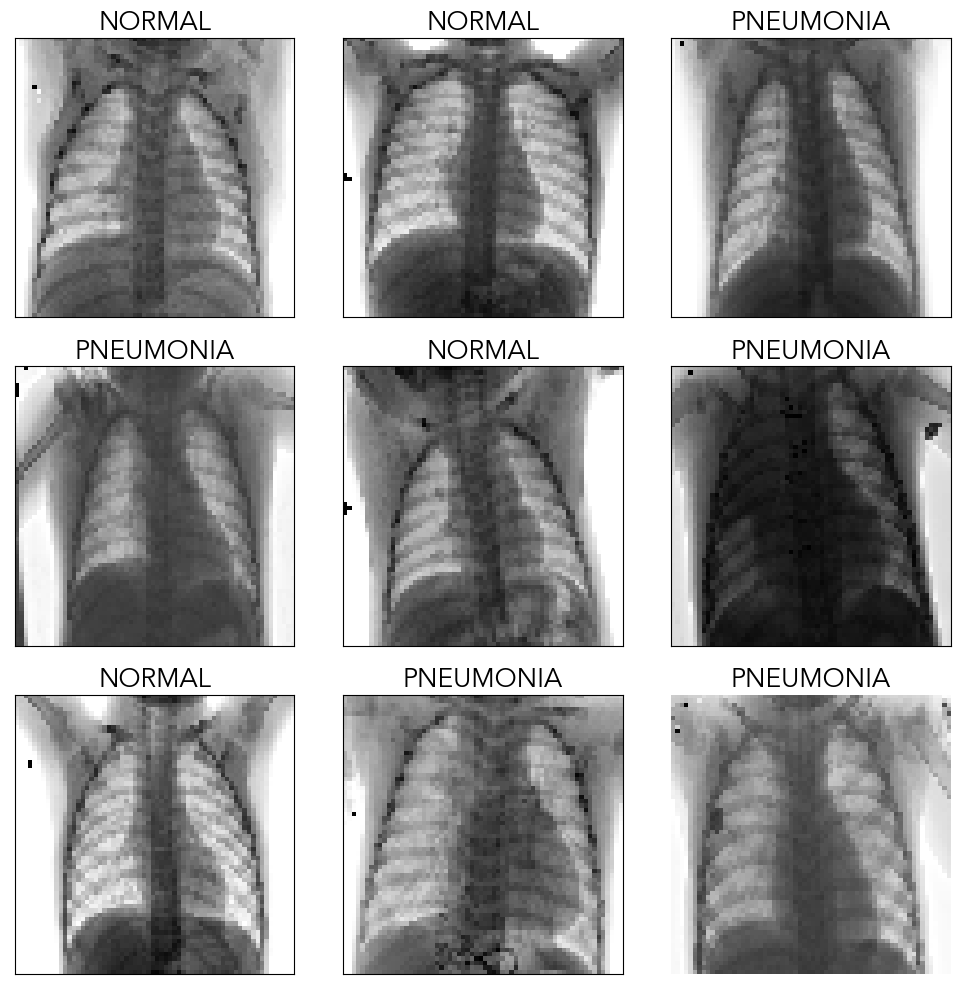

In [66]:
with plt.style.context('images/presentation.mplstyle'):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        ax = axes[i//3][i%3]
        ax.imshow(image_batch[i], cmap=plt.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])

        label = label_batch.numpy().astype('uint8')[i,0]
        ax.set_title(class_names[label])

    fig.tight_layout()

    plt.axis('off')
    plt.show()

## Model Building and Evaluation

### Dummy Model

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

In [11]:
dummy_clf.score(train_images,train_labels)

0.65625

In [12]:
dummy_clf.score(val_images,val_labels)

0.71875

In [13]:
dummy_clf.score(test_images,test_labels)

0.75

### Model 1: Baseline Neural Network

In [ ]:
np.random.seed(123)
model1 = models.Sequential()
model1.add(layers.Dense(2, activation='relu', input_shape=(12288,)))

In [ ]:
model1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

In [ ]:
results_train = model1.evaluate(train_img, train_y)

In [ ]:
results_test = model1.evaluate(test_img, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 2: Neural Network with Dense Layers

In [ ]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Dense(200, activation='relu', input_shape=(12288,)))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

In [ ]:
results_train = model2.evaluate(train_img, train_y)

In [ ]:
results_test = model2.evaluate(test_img, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 3: Neural Network with Dense and Drop Layers

In [ ]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Dense(200, activation='relu', input_shape=(12288,)))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(25, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(7, activation='relu'))
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

In [ ]:
results_train = model3.evaluate(train_img, train_y)

In [ ]:
results_test = model3.evaluate(test_img, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 4: Convolutional Neural Network (CNN)

In [ ]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [ ]:
history4 = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

In [ ]:
results_train = model.evaluate(train_images, train_y)

In [ ]:
results_test = model.evaluate(test_images, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 5: Transfer Learning - ResNet50V2

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

In [ ]:
model2 = Sequential()

model2.add(resnet50)    
model2.add(Flatten())
model2.add(Dense(units = 128, activation = "relu"))
model2.add(Dropout(0.5))

model2.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
resnet50.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model2.trainable_weights))

In [ ]:
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
hist2 = model2.fit(train2,validation_data=val2,epochs=5)

In [ ]:
test_results2 = model2.evaluate(test2)

In [ ]:
model2.summary()

### Model 6: Transfer Learning VGG19

## Analysis, Conclusions, and Future Work